In [1]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import numpy as np
from torchinfo import summary

In [6]:
### Ici, on va jouer sur le nombre de couches et les fonctions d'activations
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # Aplatit les entrées si ce n'est pas le cas
      nn.Linear(input_features, 512),
      nn.Sigmoid(), # nn.ReLU(),
      nn.Linear(512,128),
      nn.Sigmoid(), # nn.ReLU(),
      nn.Linear(128, 10)   # 10 car le nombre de classes = 10
    )

  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
    '''Forward pass'''
    return self.layers(x)


# class MLP(nn.Module):
#   '''
#     Multilayer Perceptron.
#   '''
#   def __init__(self,input_features=128):
#     super().__init__()
#     self.layers = nn.Sequential(
#       nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
#       nn.Linear(input_features, 512),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(512,256),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(256,128),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(128, 10)
#     )

# class MLP(nn.Module):
#   '''
#     Multilayer Perceptron.
#   '''
#   def __init__(self,input_features=128):
#     super().__init__()
#     self.layers = nn.Sequential(
#       nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
#       nn.Linear(input_features, 1024),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(1024,512),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(512,256),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(256,128),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(128, 10)
#     )


In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Début de la boucle d'entraînement
    size = len(dataloader.dataset)  # Taille totale du jeu de données
    nb_batches = len(dataloader)     # Nombre total de lots dans le jeu de données
    epoch_loss = 0                   # Initialisation de la perte totale pour l'époque

    for batch, (X, y) in enumerate(dataloader):
        # X : données d'entrée, y : étiquettes correspondantes

        # Calcul de la prédiction du modèle et de la perte
        pred = model(X.float())  # Utilisation du modèle pour prédire les sorties
        loss = loss_fn(pred, y)  # Calcul de la perte entre les prédictions et les étiquettes réelles
        epoch_loss += loss.item()  # Ajout de la perte de ce lot à la perte totale de l'époque

        # Rétropropagation (Backpropagation)
        optimizer.zero_grad()  # Réinitialisation des gradients accumulés dans les paramètres du modèle
        loss.backward()       # Calcul des gradients par rétropropagation
        optimizer.step()       # Mise à jour des paramètres du modèle en fonction des gradients

    # Calcul de la perte moyenne pour l'époque et affichage
    average_loss = epoch_loss / nb_batches
    #print(f"\nPerte d'entraînement :", average_loss)

    # Retourne la perte moyenne pour l'époque
    return average_loss

def valid_loop(dataloader, model, loss_fn):
    # Début de la boucle de validation
    size = len(list(dataloader.dataset))  # Taille totale du jeu de données de validation
    nb_batches = len(dataloader)           # Nombre total de lots dans le jeu de données
    valid_loss = 0                         # Initialisation de la perte de validation

    with torch.no_grad():
        # Désactive le calcul des gradients pendant la validation
        for X, y in dataloader:
            # X : données d'entrée, y : étiquettes correspondantes

            # Calcul de la prédiction du modèle et de la perte
            pred = model(X.float())  # Utilisation du modèle pour prédire les sorties
            valid_loss += loss_fn(pred, y).item()  # Ajout de la perte de ce lot à la perte totale de validation

    # Calcul de la perte moyenne de validation et affichage
    valid_loss /= nb_batches
    #print("Perte de validation :", valid_loss)

    # Retourne la perte moyenne de validation
    return valid_loss

def perf_loop(dataloader, model):
    # Début de la boucle de performance
    Total = len(list(dataloader.dataset))  # Nombre total d'exemples dans le jeu de données de test
    nb_batches = len(dataloader)            # Nombre total de lots dans le jeu de données
    Positifs = 0                            # Initialisation du compteur de prédictions correctes

    with torch.no_grad():
        # Désactive le calcul des gradients pendant la performance
        for X, y in dataloader:
            # X : données d'entrée, y : étiquettes correspondantes

            # Calcul de la prédiction du modèle
            pred = model(X.float())  # Utilisation du modèle pour prédire les sorties

            # Calcul des probabilités de classe avec Softmax
            prob_pred = nn.Softmax(dim=1)(pred)

            # Prédiction de la classe avec la probabilité maximale
            y_pred = torch.argmax(prob_pred, dim=1)

            # Comparaison des prédictions avec les étiquettes réelles
            similaires = np.array(y_pred == y)
            Positifs += np.sum(similaires)

    # Retourne le nombre total de prédictions correctes, le nombre total d'exemples, et la dernière prédiction
    return Positifs, Total, y_pred

def affichage(dataloader, message):
  fig1, axs1 = plt.subplots(1,6,figsize=(6,1))
  image_batch, label_batch = next(iter(dataloader))
  for i in range(6):
    image = image_batch[i].squeeze().numpy() # squeeze les dimensions de longueur 1 : ici la dimension du canal de l'image
    message += str(label_batch[i].numpy())+" "
    plt.subplot(1,6,i+1)
    plt.imshow(image, cmap="gray")
  print(message)
  plt.show()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
#Set fixed random number seed
torch.manual_seed(42)

# Prepare MNIST dataset
dataset = MNIST(os.getcwd(), train = True, download=True, transform=transforms.ToTensor())
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/souna/Bureau/Master/master1/S2/DeepLearning/TP2
    Split: Train
    StandardTransform
Transform: ToTensor()

Train :5 1 4 5 1 1 


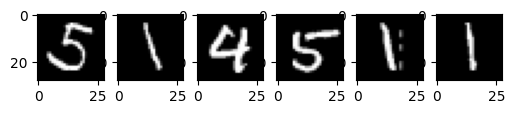

Valid :6 8 5 1 0 9 


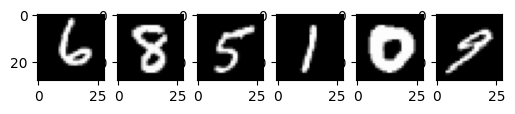

In [18]:
N = len(dataset)
N_train = int(N * 0.9)
N_valid = N - N_train
BATCH_SIZE = 64 # 128   
EPOCHS = 20 # 60
LEARNING_RATE = 1e-2 # 1e-3
OPTIM = "SGD" # "ADAM"
Model_name = "Mon_meilleur_MLP"

############### POUR LES FEATURES PIXELS #############
# il faut construire la valid et le train
train_dataset, valid_dataset = random_split(dataset, [N_train, N_valid])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
affichage(trainloader,"Train :")
affichage(validloader,"Valid :")

In [19]:
dim = 28 * 28
summary(model=MLP(input_features = dim),
        input_size=(BATCH_SIZE, 1, 28, 28), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
MLP (MLP)                                [64, 1, 28, 28]      [64, 10]             --                   True
├─Sequential (layers)                    [64, 1, 28, 28]      [64, 10]             --                   True
│    └─Flatten (0)                       [64, 1, 28, 28]      [64, 784]            --                   --
│    └─Linear (1)                        [64, 784]            [64, 512]            401,920              True
│    └─Sigmoid (2)                       [64, 512]            [64, 512]            --                   --
│    └─Linear (3)                        [64, 512]            [64, 128]            65,664               True
│    └─Sigmoid (4)                       [64, 128]            [64, 128]            --                   --
│    └─Linear (5)                        [64, 128]            [64, 10]             1,290                True
Total params: 468,87

 10%|█         | 2/20 [00:04<00:44,  2.47s/it]

best validation loss : 2.286530375480652


 15%|█▌        | 3/20 [00:07<00:41,  2.47s/it]

best validation loss : 2.2737495949927795


 20%|██        | 4/20 [00:09<00:39,  2.47s/it]

best validation loss : 2.253989135965388


 25%|██▌       | 5/20 [00:12<00:37,  2.50s/it]

best validation loss : 2.2104078962447797


 30%|███       | 6/20 [00:14<00:34,  2.46s/it]

best validation loss : 2.1073801010213


 35%|███▌      | 7/20 [00:17<00:31,  2.43s/it]

best validation loss : 1.8861075906043356


 40%|████      | 8/20 [00:19<00:28,  2.40s/it]

best validation loss : 1.5837519257626635


 45%|████▌     | 9/20 [00:21<00:26,  2.41s/it]

best validation loss : 1.3229795136350266


 50%|█████     | 10/20 [00:24<00:24,  2.41s/it]

best validation loss : 1.1282911402113893


 55%|█████▌    | 11/20 [00:26<00:21,  2.42s/it]

best validation loss : 0.9914016818746607


 60%|██████    | 12/20 [00:29<00:19,  2.42s/it]

best validation loss : 0.8967329320755411


 65%|██████▌   | 13/20 [00:31<00:16,  2.42s/it]

best validation loss : 0.8278174159374643


 70%|███████   | 14/20 [00:34<00:14,  2.40s/it]

best validation loss : 0.7703634563912737


 75%|███████▌  | 15/20 [00:36<00:12,  2.41s/it]

best validation loss : 0.7208662534013708


 80%|████████  | 16/20 [00:38<00:09,  2.41s/it]

best validation loss : 0.6752982310792233


 85%|████████▌ | 17/20 [00:41<00:07,  2.41s/it]

best validation loss : 0.6336149075563918


 90%|█████████ | 18/20 [00:43<00:04,  2.43s/it]

best validation loss : 0.5971168929592092


 95%|█████████▌| 19/20 [00:46<00:02,  2.42s/it]

best validation loss : 0.5657278660764086


100%|██████████| 20/20 [00:48<00:00,  2.44s/it]

best validation loss : 0.5415604028930056
Apprentisage terminé.



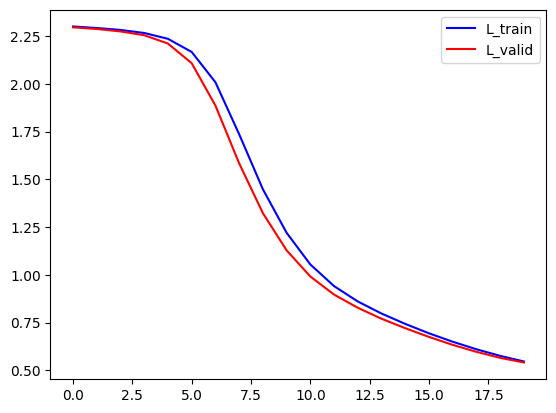

In [20]:
#################  Instanciation du MLP #################
dim = 28 * 28  # dimension des images MNIST
my_MLP = MLP(input_features = dim)
my_loss = nn.CrossEntropyLoss()
if OPTIM == "SGD":
    my_optimizer = torch.optim.SGD(my_MLP.parameters(), lr=LEARNING_RATE)
elif OPTIM == "ADAM":
    my_optimizer = torch.optim.Adam(my_MLP.parameters(), lr=LEARNING_RATE)
else:
    print("Optimiseur inconnu !!!!")

############      BOUCLES D'APPRENTISSAGE     ###########
train_loss = []
valid_loss = []
for t in tqdm(range(EPOCHS)):
    train_loss.append(train_loop(trainloader, my_MLP, my_loss, my_optimizer))
    # on test à chaque itération
    valid_loss.append(valid_loop(validloader, my_MLP, my_loss))
    # mettre ici le Early Stopping
    if t == 0:
        best_valid_loss = valid_loss[-1]
    else:
        if valid_loss[-1] < best_valid_loss:
            best_valid_loss = valid_loss[-1]
            print(f"best validation loss : {best_valid_loss}")
            # on mémorise ce modèle
            best_iter = t
            torch.save(my_MLP.state_dict(), Model_name)

print('Apprentisage terminé.\n')

# visu des loss train et test
plt.figure()
plt.plot(train_loss,"b",label="L_train")
plt.plot(valid_loss,"r",label="L_valid")
plt.legend()

Test :7 2 1 0 4 1 


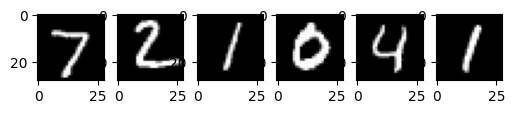

Taux de reco en Test: 8484 / 10000 = 84.84 % de réussite
Meilleure époque : 20
Nombre de paramètres libres: 468874


/tmp/ipykernel_34013/1268584892.py:70: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  similaires = np.array(y_pred == y)


In [21]:
############## on teste maintenaant les performances ################
test_dataset = MNIST(os.getcwd(), train = False, download=True, transform=transforms.ToTensor())
N_test = len(test_dataset)

##############
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=N_test, shuffle=False, num_workers=1)
affichage(testloader,"Test :")

my_best_MLP = MLP(input_features = dim)
my_best_MLP.load_state_dict(torch.load(Model_name))
Positifs, Total, y_pred = perf_loop(testloader, my_best_MLP)
print("Taux de reco en Test:",Positifs,"/", Total, "=", (Positifs/Total)*100, "% de réussite")
print("Meilleure époque :",best_iter+1)

nb_train_param = count_parameters(my_best_MLP)
print("Nombre de paramètres libres:",nb_train_param)

In [22]:
#---------------------------------------------------------------------------------

100%|██████████| 20/20 [00:44<00:00,  2.24s/it]


Apprentisage terminé.



100%|██████████| 20/20 [01:01<00:00,  3.08s/it]

Apprentisage terminé.



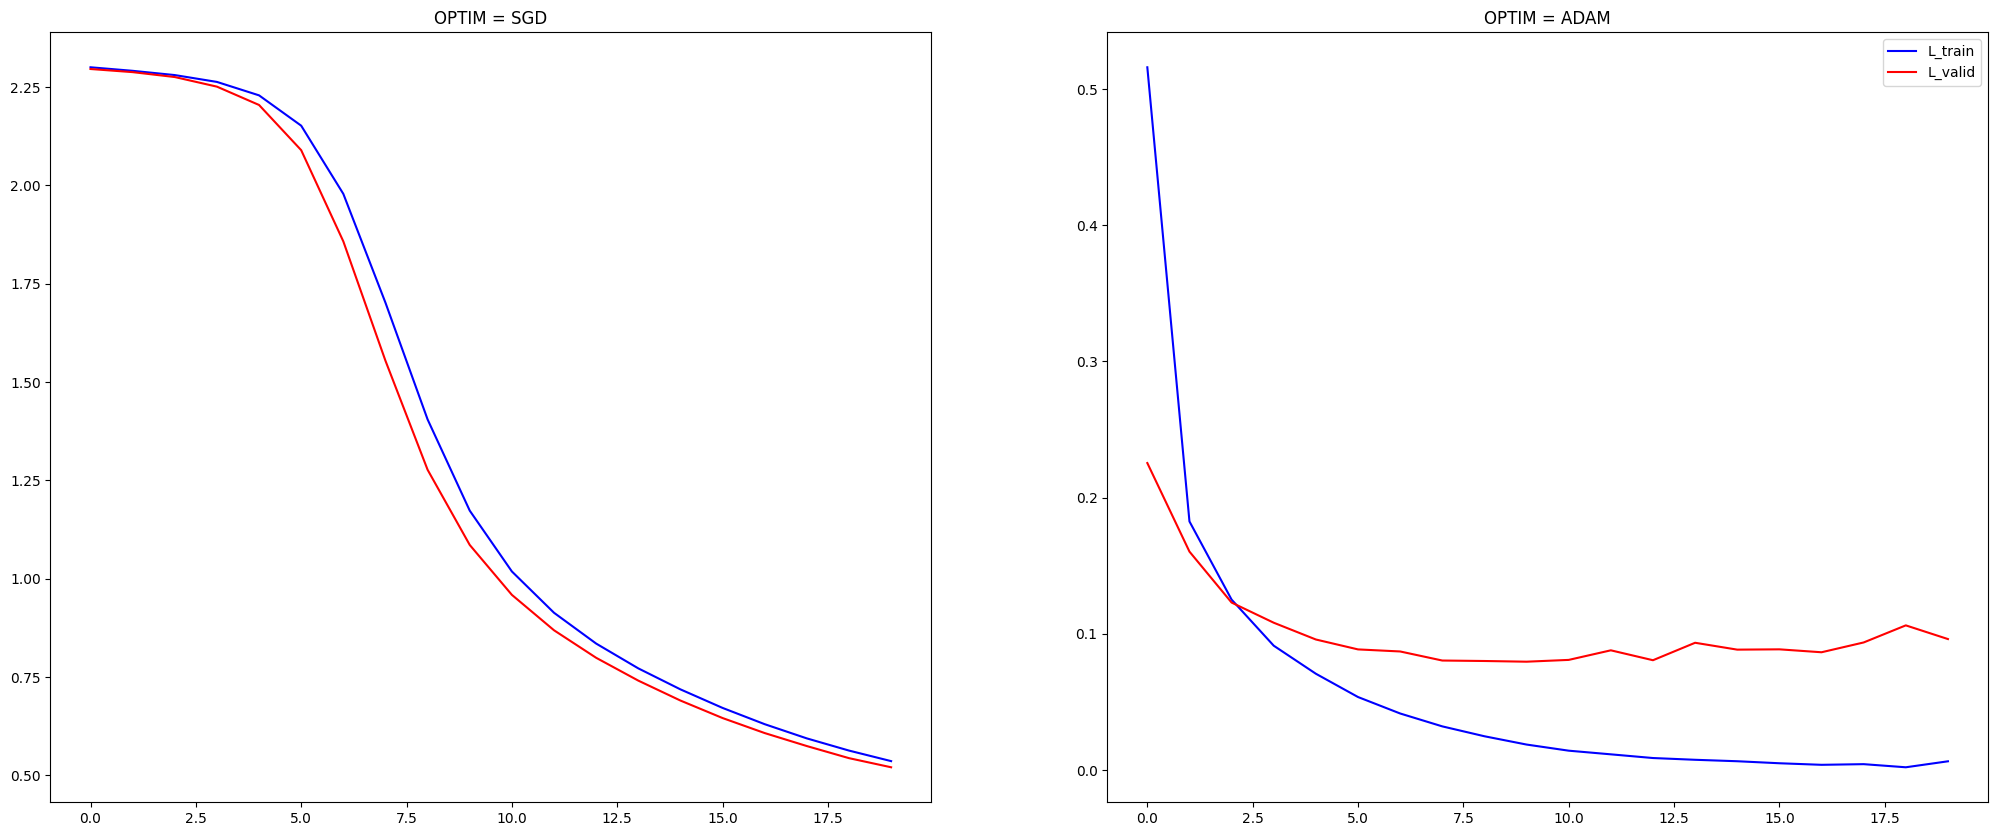

In [16]:
paramet=[["SGD",1e-2],["ADAM",1e-3]]
plt.subplots(1,2,figsize =(25, 10))
i=1
for val in paramet:
        N = len(dataset)
        N_train = int(N * 0.9)
        N_valid = N - N_train
        BATCH_SIZE = 64 # 128   
        EPOCHS = 20 # 60
        LEARNING_RATE = val[1] # 1e-3
        OPTIM = val[0] # "ADAM"
        Model_name = "Mon_meilleur_MLP"

        ############### POUR LES FEATURES PIXELS #############
        # il faut construire la valid et le train
        train_dataset, valid_dataset = random_split(dataset, [N_train, N_valid])
        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
        #-----------------------
        dim = 28 * 28
        #---------------------------
        #################  Instanciation du MLP #################
        dim = 28 * 28  # dimension des images MNIST
        my_MLP = MLP(input_features = dim)
        my_loss = nn.CrossEntropyLoss()
        if OPTIM == "SGD":
          my_optimizer = torch.optim.SGD(my_MLP.parameters(), lr=LEARNING_RATE)
        elif OPTIM == "ADAM":
          my_optimizer = torch.optim.Adam(my_MLP.parameters(), lr=LEARNING_RATE)
        else:
          print("Optimiseur inconnu !!!!")

        ############      BOUCLES D'APPRENTISSAGE     ###########
        train_loss = []
        valid_loss = []
        for t in tqdm(range(EPOCHS)):
           train_loss.append(train_loop(trainloader, my_MLP, my_loss, my_optimizer))
        # on test à chaque itération
           valid_loss.append(valid_loop(validloader, my_MLP, my_loss))
        # mettre ici le Early Stopping
           if t == 0:
                best_valid_loss = valid_loss[-1]
           else:
                if valid_loss[-1] < best_valid_loss:
                    best_valid_loss = valid_loss[-1]
                #print(f"best validation loss : {best_valid_loss}")
                # on mémorise ce modèle
                best_iter = t
                torch.save(my_MLP.state_dict(), Model_name)

        print('Apprentisage terminé.\n')

        # visu des loss train et test
        plt.subplot(1,2,i)
        plt.title(f'OPTIM = {val[0]}')
        plt.plot(train_loss,"b",label="L_train")
        plt.plot(valid_loss,"r",label="L_valid")

        i+=1
plt.legend()
plt.show()


In [9]:
### Ici, on va jouer sur le nombre de couches et les fonctions d'activations
class MLP1(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # Aplatit les entrées si ce n'est pas le cas
      nn.Linear(input_features, 512),
      nn.ReLU(),
      nn.Linear(512,128),
      nn.ReLU(),
      nn.Linear(128, 10)   # 10 car le nombre de classes = 10
    )

  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
    '''Forward pass'''
    return self.layers(x)
  
N = len(dataset)
N_train = int(N * 0.9)
N_valid = N - N_train
BATCH_SIZE = 64 # 128   
EPOCHS = 20 # 60
LEARNING_RATE = 1e-2 # 1e-3
OPTIM = "SGD" # "ADAM"
Model_name = "Mon_meilleur_MLP"

############### POUR LES FEATURES PIXELS #############
# il faut construire la valid et le train
train_dataset, valid_dataset = random_split(dataset, [N_train, N_valid])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [13]:
#################  Instanciation du MLP #################
dim = 28 * 28  # dimension des images MNIST
def myclasse(modele,focntion):
        my_MLP = modele(input_features = dim)
        my_loss = nn.CrossEntropyLoss()
        if OPTIM == "SGD":
            my_optimizer = torch.optim.SGD(my_MLP.parameters(), lr=LEARNING_RATE)
        elif OPTIM == "ADAM":
            my_optimizer = torch.optim.Adam(my_MLP.parameters(), lr=LEARNING_RATE)
        else:
            print("Optimiseur inconnu !!!!")

        ############      BOUCLES D'APPRENTISSAGE     ###########
        train_loss = []
        valid_loss = []
        for t in tqdm(range(EPOCHS)):
            train_loss.append(train_loop(trainloader, my_MLP, my_loss, my_optimizer))
            # on test à chaque itération
            valid_loss.append(valid_loop(validloader, my_MLP, my_loss))
            # mettre ici le Early Stopping
            if t == 0:
                best_valid_loss = valid_loss[-1]
            else:
                if valid_loss[-1] < best_valid_loss:
                    best_valid_loss = valid_loss[-1]
                    print(f"best validation loss : {best_valid_loss}")
                    # on mémorise ce modèle
                    best_iter = t
                    torch.save(my_MLP.state_dict(), Model_name)

        print('Apprentisage terminé.\n')

        # visu des loss train et test
        
        plt.title(f'Fonction d activation {focntion}')
        plt.plot(train_loss,"b",label="L_train")
        plt.plot(valid_loss,"r",label="L_valid")
        plt.legend()

 10%|█         | 2/20 [00:04<00:39,  2.20s/it]

best validation loss : 2.2861756872623524


 15%|█▌        | 3/20 [00:06<00:37,  2.23s/it]

best validation loss : 2.270482060757089


 20%|██        | 4/20 [00:08<00:36,  2.26s/it]

best validation loss : 2.2441331097420227


 25%|██▌       | 5/20 [00:11<00:34,  2.29s/it]

best validation loss : 2.184111940099838


 30%|███       | 6/20 [00:13<00:31,  2.27s/it]

best validation loss : 2.0449535250663757


 35%|███▌      | 7/20 [00:15<00:29,  2.30s/it]

best validation loss : 1.7946376458127449


 40%|████      | 8/20 [00:18<00:27,  2.28s/it]

best validation loss : 1.5172176931766754


 45%|████▌     | 9/20 [00:20<00:25,  2.28s/it]

best validation loss : 1.2969885798210794


 50%|█████     | 10/20 [00:22<00:22,  2.28s/it]

best validation loss : 1.1164192126152364


 55%|█████▌    | 11/20 [00:25<00:20,  2.30s/it]

best validation loss : 0.9791534302082467


 60%|██████    | 12/20 [00:27<00:18,  2.28s/it]

best validation loss : 0.8795937756274609


 65%|██████▌   | 13/20 [00:29<00:15,  2.27s/it]

best validation loss : 0.8072471827902692


 70%|███████   | 14/20 [00:31<00:13,  2.28s/it]

best validation loss : 0.7447343811075738


 75%|███████▌  | 15/20 [00:34<00:11,  2.28s/it]

best validation loss : 0.694029653960086


 80%|████████  | 16/20 [00:36<00:09,  2.29s/it]

best validation loss : 0.6500746306586773


 85%|████████▌ | 17/20 [00:38<00:06,  2.28s/it]

best validation loss : 0.6125339145990129


 90%|█████████ | 18/20 [00:41<00:04,  2.33s/it]

best validation loss : 0.5812195051223674


 95%|█████████▌| 19/20 [00:43<00:02,  2.30s/it]

best validation loss : 0.5528826428220627


100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


best validation loss : 0.5314137117659792
Apprentisage terminé.



 10%|█         | 2/20 [00:04<00:40,  2.27s/it]

best validation loss : 0.45182274725842986


 15%|█▌        | 3/20 [00:06<00:38,  2.27s/it]

best validation loss : 0.37392629476937844


 20%|██        | 4/20 [00:09<00:36,  2.26s/it]

best validation loss : 0.3320126195854329


 25%|██▌       | 5/20 [00:11<00:33,  2.26s/it]

best validation loss : 0.30867659942583836


 30%|███       | 6/20 [00:13<00:31,  2.25s/it]

best validation loss : 0.2912018044673382


 35%|███▌      | 7/20 [00:15<00:29,  2.25s/it]

best validation loss : 0.27380015518754086


 40%|████      | 8/20 [00:18<00:27,  2.26s/it]

best validation loss : 0.2602457210738608


 45%|████▌     | 9/20 [00:20<00:24,  2.27s/it]

best validation loss : 0.24953815998866202


 50%|█████     | 10/20 [00:22<00:23,  2.31s/it]

best validation loss : 0.23636593451683827


 55%|█████▌    | 11/20 [00:25<00:20,  2.29s/it]

best validation loss : 0.22595193633373747


 60%|██████    | 12/20 [00:27<00:18,  2.29s/it]

best validation loss : 0.21918215134993513


 65%|██████▌   | 13/20 [00:29<00:15,  2.28s/it]

best validation loss : 0.20634926023318412


 70%|███████   | 14/20 [00:31<00:13,  2.28s/it]

best validation loss : 0.19820203644005543


 75%|███████▌  | 15/20 [00:34<00:11,  2.29s/it]

best validation loss : 0.19301974321616458


 80%|████████  | 16/20 [00:36<00:09,  2.28s/it]

best validation loss : 0.18334859801813008


 85%|████████▌ | 17/20 [00:38<00:06,  2.29s/it]

best validation loss : 0.1788433840537959


 90%|█████████ | 18/20 [00:41<00:04,  2.29s/it]

best validation loss : 0.17857995258763115


 95%|█████████▌| 19/20 [00:43<00:02,  2.30s/it]

best validation loss : 0.16776536694390976


100%|██████████| 20/20 [00:45<00:00,  2.28s/it]

best validation loss : 0.16366728636971178
Apprentisage terminé.



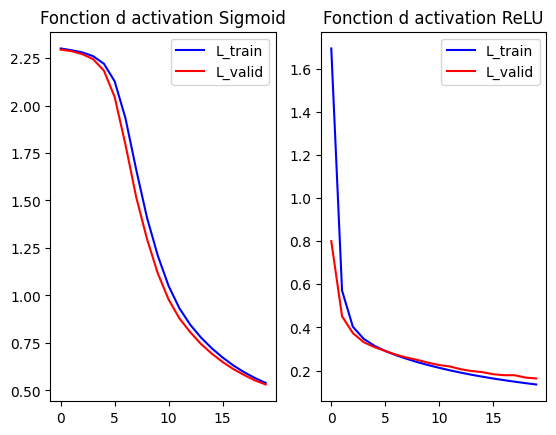

In [15]:
plt.subplots(1,2)
plt.subplot(1,2,1)
myclasse(MLP,'Sigmoid')
plt.subplot(1,2,2)
myclasse(MLP1,'ReLU')

In [27]:
### Ici, on va jouer sur le nombre de couches et les fonctions d'activations
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # Aplatit les entrées si ce n'est pas le cas
      nn.Linear(input_features, 512),
      nn.ReLU(),
      nn.Linear(512,128),
      nn.ReLU(),
      nn.Linear(128, 10)   # 10 car le nombre de classes = 10
    )

  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
    '''Forward pass'''
    return self.layers(x)
  
class MLP2(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # Aplatit les entrées si ce n'est pas le cas
      nn.Linear(input_features, 256),
      nn.ReLU(),
      nn.Linear(256, 10)   # 10 car le nombre de classes = 10
    )

  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
    '''Forward pass'''
    return self.layers(x)


class MLP4(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self,input_features=128):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
      nn.Linear(input_features, 512),
      nn.ReLU(), #nn.Sigmoid(),
      nn.Linear(512,256),
      nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
      nn.Linear(256,128),
      nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
      nn.Linear(128, 10)
    )
  def forward(self, x):      # l'activation softmax est mise automatiquement dans la loss CrossEntropy
      '''Forward pass'''
      return self.layers(x)

# class MLP(nn.Module):
#   '''
#     Multilayer Perceptron.
#   '''
#   def __init__(self,input_features=128):
#     super().__init__()
#     self.layers = nn.Sequential(
#       nn.Flatten(),                   # on vectorise les entrées si ce n'est pas le cas
#       nn.Linear(input_features, 1024),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(1024,512),
#       nn.ReLU(), #nn.Sigmoid(),
#       nn.Linear(512,256),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(256,128),
#       nn.ReLU(), #nn.Sigmoid(), nn.ReLU()
#       nn.Linear(128, 10)
#     )


 10%|█         | 2/20 [00:06<00:59,  3.31s/it]

best validation loss : 0.0998633453384676


 15%|█▌        | 3/20 [00:09<00:56,  3.31s/it]

best validation loss : 0.08759603429427172


 20%|██        | 4/20 [00:13<00:52,  3.27s/it]

best validation loss : 0.07837873441167176


100%|██████████| 20/20 [01:04<00:00,  3.23s/it]


Apprentisage terminé.



 10%|█         | 2/20 [00:07<01:06,  3.67s/it]

best validation loss : 0.11286318991729553


 15%|█▌        | 3/20 [00:11<01:02,  3.68s/it]

best validation loss : 0.10460897644565618


 20%|██        | 4/20 [00:14<00:59,  3.69s/it]

best validation loss : 0.08493547432837968


100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


Apprentisage terminé.



 10%|█         | 2/20 [00:04<00:41,  2.32s/it]

best validation loss : 0.10719175741789823


 15%|█▌        | 3/20 [00:06<00:38,  2.28s/it]

best validation loss : 0.08945275509254412


 20%|██        | 4/20 [00:09<00:36,  2.28s/it]

best validation loss : 0.07962182276149063


 25%|██▌       | 5/20 [00:11<00:34,  2.27s/it]

best validation loss : 0.07662717114262124


 30%|███       | 6/20 [00:13<00:31,  2.27s/it]

best validation loss : 0.07281853237308245


100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Apprentisage terminé.



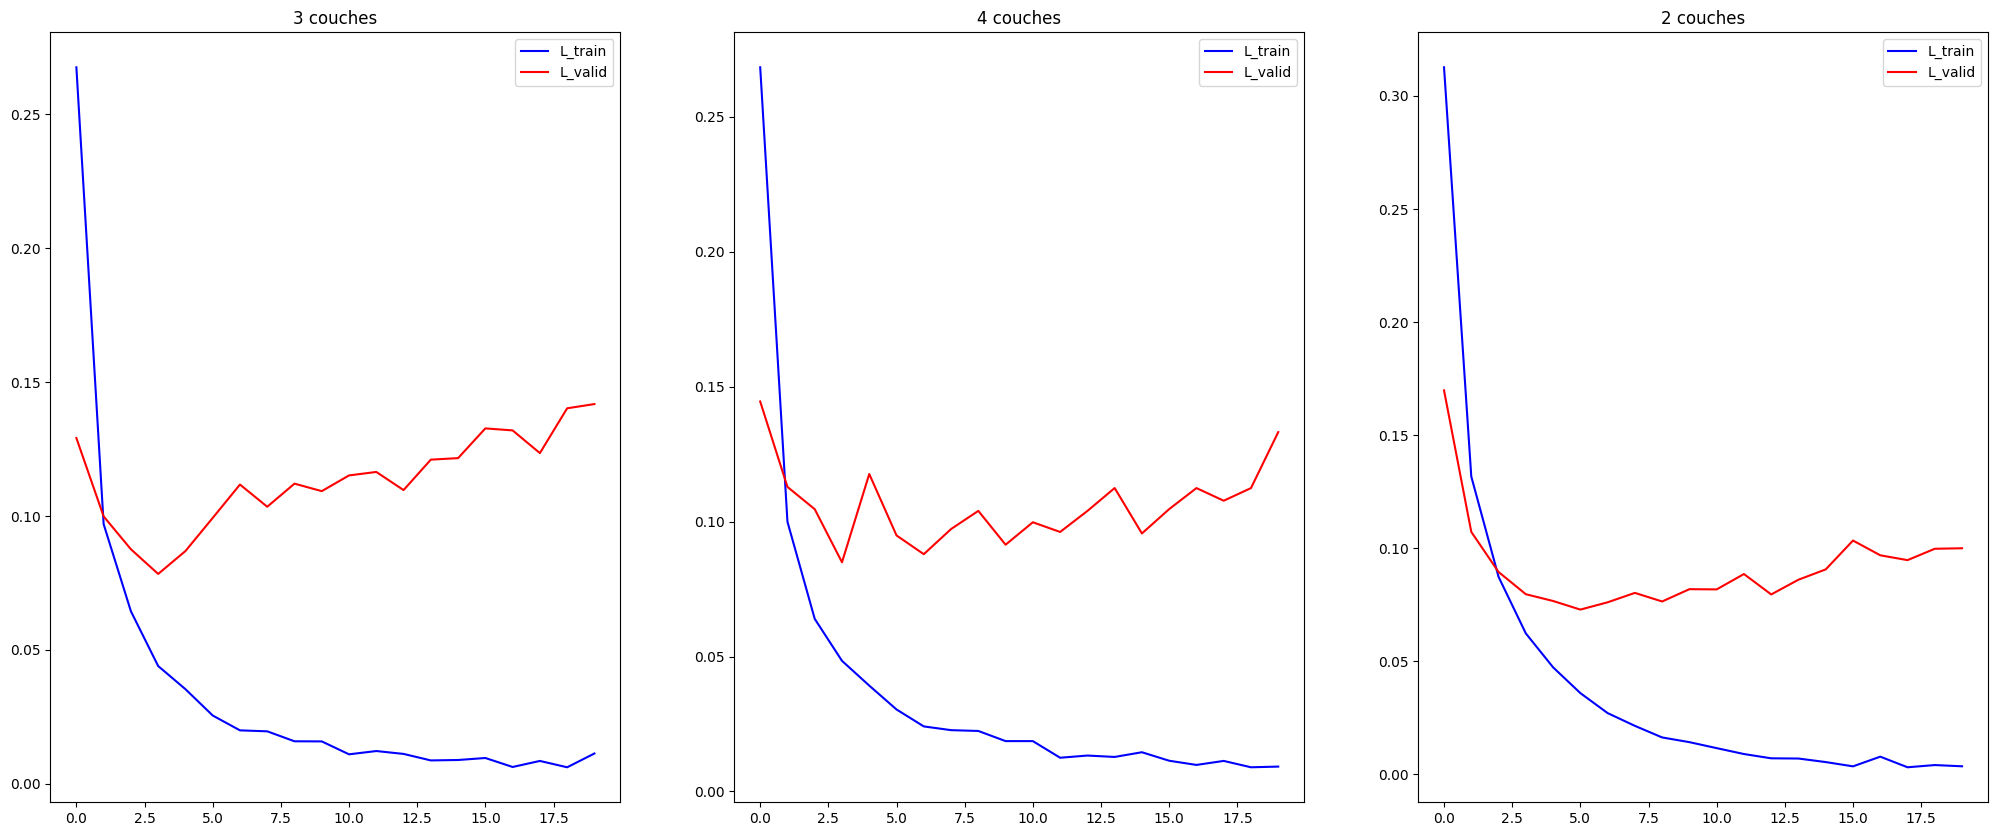

In [29]:
#################  Instanciation du MLP #################
N = len(dataset)
N_train = int(N * 0.9)
N_valid = N - N_train
BATCH_SIZE = 64 # 128   
EPOCHS = 20 # 60
LEARNING_RATE = 1e-3 # 1e-3
OPTIM = "ADAM" # "ADAM"
Model_name = "Mon_meilleur_MLP"
plt.subplots(1,3,figsize =(25, 10))
i=1
mod=[MLP,MLP4,MLP2]
nom=['3 couches','4 couches','2 couches']
for modd in mod:
    ############### POUR LES FEATURES PIXELS #############
    # il faut construire la valid et le train
    train_dataset, valid_dataset = random_split(dataset, [N_train, N_valid])
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
    dim = 28 * 28  # dimension des images MNIST
    my_MLP = modd(input_features = dim)
    my_loss = nn.CrossEntropyLoss()
    if OPTIM == "SGD":
        my_optimizer = torch.optim.SGD(my_MLP.parameters(), lr=LEARNING_RATE)
    elif OPTIM == "ADAM":
        my_optimizer = torch.optim.Adam(my_MLP.parameters(), lr=LEARNING_RATE)
    else:
        print("Optimiseur inconnu !!!!")

    ############      BOUCLES D'APPRENTISSAGE     ###########
    train_loss = []
    valid_loss = []
    for t in tqdm(range(EPOCHS)):
        train_loss.append(train_loop(trainloader, my_MLP, my_loss, my_optimizer))
        # on test à chaque itération
        valid_loss.append(valid_loop(validloader, my_MLP, my_loss))
        # mettre ici le Early Stopping
        if t == 0:
            best_valid_loss = valid_loss[-1]
        else:
            if valid_loss[-1] < best_valid_loss:
                best_valid_loss = valid_loss[-1]
                print(f"best validation loss : {best_valid_loss}")
                # on mémorise ce modèle
                best_iter = t
                torch.save(my_MLP.state_dict(), Model_name)

    print('Apprentisage terminé.\n')

    # visu des loss train et test
    plt.subplot(1,3,i)
    plt.title(f'{nom[i-1]}')
    plt.plot(train_loss,"b",label="L_train")
    plt.plot(valid_loss,"r",label="L_valid")
    plt.legend()
    i+=1